# An Accurate Implementation of the Studentized Range Distribution for Python

By Samuel Wallan, Dominic Chmiel, and Matt Haberland


## Introduction

As data becomes more and more accessible in a world awash with computers, it can be tempting follow a practice called "p-hacking", or misusing data analysis in order to show an artificially  significant statistical corellation. For example, there appears to be a correllation between the number of letters in the Scripps National Spelling Bee and the number of people killed by venomous spiders in the United States every year. Several carefully designed statistical tests that gaurd against this practice rely on the studentized range distrbution by accounting for the number of comparisons in their statistic and p-value. One such test is Tukey's HSD (Honest Significant Difference) test, which utilizes the studentized range distribution's Percent Point Function (PPF), to measure the range of data from a normally distributed sample.

Precomputed tables exist for the studentized range distrbution, but can only approximate results should input data not fall within the tables' bounds. However, the probability distribution function (PDF) and cumulative distribution function (CDF) for the studentized range are computationally challenging to evaluate due to their complicated double integrals. The PPF is the inverse of the CDF. Therefore, in this paper we present a pythonic, fast, accurate, and direct implementation of the studentized range distribution for SciPy in addition to tests that demonstrate its accuracy and performance. 

## The Distribution

The studentized range's PDF and CDF take the following forms, respectively [1]:

$$     f_\text{R}(q;k,\nu) = \frac{\sqrt{2\pi\,}\,k\,(k-1)\,\nu^{\nu/2}}{\Gamma(\nu /2)\,2^{\left(\nu/2-1\right)}}\int_0^\infty s^\nu \, \phi(\sqrt{\nu\,} \,s)\,\left[\int_{-\infty}^\infty \phi(z+q\,s)\,\phi(z)\, \left[\Phi(z+q\,s)-\Phi(z)\right]^{k-2} \, \mathrm{d}z\right] \, \mathrm{d}s \tag{1}
$$

$$ F_\text{R}(q;k,\nu) = \frac{\sqrt{2\pi\,}\,k\,\nu^{\nu/2}}{\,\Gamma(\nu/2)\,2^{(\nu/2-1)}\,} \int_0^\infty s^{\nu-1} \phi(\sqrt{\nu\,}\,s) \left[\int_{-\infty}^\infty \phi(z) \left[\Phi(z+q\,s)-\Phi(z)\right]^{k-1} \, \mathrm{d}z \right] \, \mathrm{d}s, \tag{2}$$

where $\phi(z)$ and $\Phi(z)$ represent the normal PDF and normal CDF, respectively.

## Implementations

### A Very Direct Implementation

To establish a baseline, we evaluate the CDF exactly as written in equation (2), using nested calls to SciPy's `integrate.quad` to evaluate the double integral.

In [ ]:
import numpy as np
from scipy.integrate import quad
from scipy.special import gamma
from scipy.stats import norm

phi = norm.pdf
Phi = norm.cdf

def cdf_singleQuad(q, k, nu):
    def inner(z, s):
      return phi(z) * (Phi(z + q * s) - Phi(z))**(k - 1)

    def outer(s):
      inner_int = quad(inner, -np.inf, np.inf, args=(s,), 
                       epsabs=1e-12, limit=1000)[0]
      return s**(nu - 1) * phi(np.sqrt(nu) * s) * inner_int

    outer_int = quad(outer, 0, np.inf, epsabs=1e-12, limit=1000)[0]
    return (np.sqrt(2 * np.pi) * k * nu**(nu/2) /
            (gamma(nu/2) * 2**(nu/2 - 1)) * outer_int)

A well known tabulatation the studentized range CDF as a function of $q$, $k$, and $\nu$, reports $q$ and $p=F(q; k, \nu)$ with two significant figures [1]. It states that $F(3.77; 3, 12)=0.95$, and `cdf_singleQuad` agrees.

In [ ]:
cdf_singleQuad(3.77, 3, 12)

0.9498176382397655

Unfortunately, `cdf_singleQuad` is very slow.

In [ ]:
python_quad = %timeit -o -r1 -n1 cdf_singleQuad(3.77, 3, 12)

1 loop, best of 1: 13.6 s per loop


This implementation is easy to verify against the original formula and therefore serves as a valuable reference, but a faster implementation is needed for inclusion in SciPy.


###  Using `optimize.dblquad`.

To remove the overhead of repeated calls to `quad`, we rearrange equation (2) to

$$ F(q; k, \nu) = \int_{0}^ {\infty} \int_{-\infty}^{\infty} s^{\nu-1} \frac{k\nu^{\nu/2}}{\Gamma(\nu/2)2^{\nu/2-1}}e^{-\nu s^2/2} \phi(z) [\Phi(sq + z) - \Phi(z)]^{k-1} \,dz \,ds \tag{3} $$

so that it can be computed with single call to SciPy's double integration function, `integrate.dblquad`. Besides moving the inner integral sign to the left, we have also moved the constant terms into the integral so that they can be included in the integrator's internal error estimate.

In [ ]:
from scipy.integrate import dblquad

def integrand_python(q, k, nu):
    def inner(s, z):
        return phi(z) * (Phi(z + q * s) - Phi(z))**(k - 1)

    def outer(s, z):
        inner_int = inner(s, z)
        return s**(nu - 1) * phi(np.sqrt(nu) * s) * inner_int

    def whole(z, s):
        return (np.sqrt(2 * np.pi) * k * nu**(nu / 2) /
                (gamma(nu / 2) * 2**(nu / 2 - 1)) * outer(s, z))
        
    return whole

def cdf_dblquad(q, k, nu):    
    return dblquad(integrand_python(q, k ,nu), 0, np.inf, -np.inf, np.inf)[0]

In [ ]:
cdf_dblquad(3.77, 3, 12)

0.9498176382396498

In [ ]:
python_dblquad = %timeit -o -r1 -n1 cdf_dblquad(3.77, 3, 12)

1 loop, best of 1: 13.2 s per loop


This simple change saves a small amount of computation time, but `cdf_dblquad` remains too slow for general use.

### Faster Normal PDF/CDF Evaluation

A more significant source of overhead is the use of SciPy's `norm.pdf` and `norm.cdf` for evaluation of $\phi$ and $\Phi$. The statistical distributions in `scipy.stats` have many useful features, but their methods are often much slower than direct calls to the underlying special functions. We eliminate this overhead by redefining `phi` and `Phi`.


In [ ]:
from scipy.special import ndtr  # the normal CDF 

phi_norm = norm.pdf
Phi_norm = norm.cdf

def phi(z):
  return (2 * np.pi)**(-.5) * np.exp(-0.5 * z * z)

def Phi(z):
  return ndtr(z)
 

For timing calculations that are very fast, we average over more than one computation.

In [ ]:
%timeit phi_norm(10)  # 0.00023118260003684554

The slowest run took 4.39 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 102 µs per loop


In [ ]:
%timeit phi(10)  # 2.008359952014871e-06

The slowest run took 36.10 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.41 µs per loop


In [ ]:
%timeit Phi_norm(10)  #0.00018655471998499707

10000 loops, best of 5: 96.8 µs per loop


In [ ]:
%timeit Phi(10)  # 3.4688199957599863e-06

The slowest run took 28.42 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.27 µs per loop


Our functions have much less overhead `norm`'s methods, so we expect that they will improve the speed of the `dblquad` integration significantly. Indeed, it does:

In [ ]:
improved_python = %timeit -o -r1 -n1 cdf_dblquad(3.77, 3, 12)

1 loop, best of 1: 494 ms per loop


This execution time may be acceptable for a single function evaluation, but `python_dblquad` remains too slow for vectorized and iterative computations.

### Optimizing the Integrand with Cython

To improve the integration speed further, we focus on computing the integrand

$$ I = s^{\nu-1} \frac{k\nu^{\nu/2}}{\Gamma(\nu/2)2^{\nu/2-1}}e^{-\nu s^2/2} \phi(z) [\Phi(sq + z) - \Phi(z)]^{k-1} \tag{4}$$

with Cython. For reference,

In [ ]:
%timeit integrand_python(1, 1, [3.77, 3, 12])

The slowest run took 8.93 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 666 ns per loop


#### Cythonizing Python Directly

As a high level programming language, Python's dynamic typing promotes ease of use but also adds significant computational time. An extension to the Python language, Cython, is designed to make C-like performance accessible from Python. This Python-like code is compiled to C or C++ and creates a Python module as the interface for use.

To begin, we process the unmodified Python code with Cython.

In [ ]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [ ]:
%%cython -a

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# The code in this cell is identical to that above; it
# must be repeated here to be processed with Cython.

import numpy as np
from scipy.special import gamma, ndtr

def phi(z):
  return (2 * np.pi)**(-.5) * np.exp(-0.5 * z * z)

def Phi(z):
  return ndtr(z)

def cdf_integrand_cython(s, z, args): 
  q, k, nu = args
  def inner(s, z):
    return phi(z) * (Phi(z + q * s) - Phi(z))**(k - 1)

  def outer(s, z):
    inner_int = inner(s, z)
    return s**(nu) * phi((nu ** .5)*s) * inner_int

  def whole(s, z):
    return (((2 * np.pi)**.5) * k * nu**(nu / 2) /
            (gamma(nu / 2) * 2**(nu /2 - 1)) * outer(s, z))

  return whole(s, z)


The bolder the highlighting in the lines above, the greater the overhead of API calls between the compiled code and Python. As most of the code is highlighted, we would not expect the Cythonized code to be much faster than the original.

In [ ]:
%timeit cdf_integrand_cython(1, 1, [3.77, 3, 12])

The slowest run took 9.34 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 9.01 µs per loop


Although this ~20% faster than the pure Python version, the speed can be improved further by minimizing the amount of interaction between C and Python.

#### Optimizing Cython


Every highlighted line hints at an interaction between C and Python. Therefore, we introduce a refactored, more Cythonic, implementation that 
- removes the Python interface for interior functions,
- declares types for variables and function returns,
- precomputes constants,
- removes Python interaction relating to division, and
- imports functions native to C for computing $\phi$ and $\Phi$.

In [ ]:
%%cython -a

cimport libc.math as math
cimport scipy.special.cython_special as cs

cdef double _phi(double z) nogil:
  cdef double inv_sqrt_2pi = 0.3989422804014327
  return inv_sqrt_2pi * math.exp(-0.5 * z * z)

cdef double _Phi(double z) nogil:
  return cs.ndtr(z)

cdef double inner(double s, double z, double q, double k, double nu) nogil:
  return _phi(z)*(_Phi(z+q*s)-_Phi(z))**(k-1)

cdef double outer(double s, double z, double q, double k, double nu) nogil:
  inner_int = inner(s, z, q, k, nu)
  return s**(nu)*_phi((nu ** .5)*s)*inner_int

cdef double constants(double s, double z, double q, double k, double nu) nogil:
  num = ((2 * math.M_PI)**.5)* k *nu**(nu/2)
  denom = (math.tgamma(nu / 2) * 2**(nu / 2 - 1))
  return  num * (denom ** -1)

cpdef double cdf_integrand_cython_optimized(double s, double z, double q, double k, double nu):
  return constants(s, z, q, k, nu) * outer(s, z, q, k, nu)

Almost all Python interaction has been eliminated, so the resulting integrand function is much faster than the original.

In [ ]:
%timeit cdf_integrand_cython_optimized(1, 1, 3.77, 3, 12)

The slowest run took 26.25 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 584 ns per loop


### Integration with Optimized Integrand

Integrating using the optimized Cython integrand is nearly three order of magnitude faster than the original Python implementation.

In [ ]:
optimized_cython = %timeit -o dblquad(cdf_integrand_cython_optimized, -np.inf,  np.inf, lambda x: 0, lambda x: np.inf, args=(3.77, 3, 12))

10 loops, best of 5: 19.6 ms per loop


### Utilize SciPy's LowLevelCallable as the Integrand


There is one remaining Python interaction that slows down integration: because `cdf_integrand_cython_optimized` is declared using `cpdef` and therefore has a Python interface, we know that `dblquad` is using the Python interface to call the function. It would be faster if the compiled code underlying `dblquad` could interact with the compiled version of the integrand directly. That is precisely what SciPy's [`LowLevelCallable`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.LowLevelCallable.html) feature allows us to do.


*Note: There are multiple possible implementations of a `LowLevelCallable`; the following is one that works in Jupyter Notebooks. Jupyter Notebook's `%%cython` magic command doesn't provide an interface for using `.pxd` files in compliation, so we must write it to the directory ourselves. The following two cells are not part of SciPy's implementation of the studentized range distribution, but allow us to demonstrate the idea on Google Colab and in Jupyter Notebooks.*


In [ ]:
# disregard this cell, it is only used to set up the LowLevelCallable.
%%cython -n tempName
cpdef fun():
  return None

In [ ]:
# disregard this cell, it is only used to set up the LowLevelCallable.
import tempName
import os
path = tempName.__file__
path_split = os.path.split(path)[0]
path_pxd = os.path.join(path_split, "studentized_range.pxd")

with open(path_pxd , "w+") as f:
  f.write("cdef double genstudentized_range_cdf(int, double*, void*) nogil")

Once past that, we compile:

In [ ]:
%%cython -f -n studentized_range
cimport libc.math as math
cimport scipy.special.cython_special as cs

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# The following code mirrors the above Cython cell. The new method is at the
# bottom of this cell.

cdef double _phi(double z) nogil:
  """evaluates the normal PDF. Used in `studentized range`"""
  cdef double inv_sqrt_2pi = 0.3989422804014327
  return inv_sqrt_2pi * math.exp(-0.5 * z * z)

cdef double _Phi(double z) nogil:
  """evaluates the normal CDF. Used in `studentized range`"""
  return cs.ndtr(z)

cdef double inner(double s, double z, double q, double k, double nu) nogil:
  return _phi(z)*(_Phi(z+q*s)-_Phi(z))**(k-1)

cdef double outer(double s, double z, double q, double k, double nu) nogil:
  inner_int = inner(s, z, q, k, nu)
  return s**(nu) * _phi((nu ** .5)*s) * inner_int

cdef double constants(double s, double z, double q, double k, double nu) nogil:
  num = ((2 * math.M_PI)**.5)* k *nu**(nu/2)
  denom = (math.tgamma(nu / 2) * 2**(nu / 2 - 1))
  return  num * (denom ** -1)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# This is new code that is formatted to work with `scipy.integrate.nquad`
cdef double genstudentized_range_cdf(int n, double * x, void * user_data) nogil:
    q = (<double *> user_data)[0]
    k = (<double *> user_data)[1]
    nu = (<double *> user_data)[2]

    z = x[0]
    s = x[1]
    return outer(s, z, q, k, nu) * constants(s, z, q, k, nu)


We could use this `LowLevelCallable` in `dblquad`, but since `dblquad` is implemented using SciPy's n-integral quadrature function `nquad`, we'll call `nquad` directly.

In [ ]:
import studentized_range
import ctypes
from scipy._lib._ccallback import LowLevelCallable
import numpy as np
from scipy.integrate import nquad

usr_data = np.array([3.77, 3, 12], float).ctypes.data_as(ctypes.c_void_p)
studentized_range_cdf_lowlevelcallable = LowLevelCallable.from_cython(studentized_range, "genstudentized_range_cdf", usr_data)
ranges = [(-np.inf, np.inf), (0, np.inf)]

In [ ]:
LLC_nquad = %timeit -o nquad(studentized_range_cdf_lowlevelcallable, ranges=ranges)[0]

100 loops, best of 5: 14.9 ms per loop


## Other Improvements


### Logarithmization

over flow underflow numerical accuracy. Some of the terms are huge (gamma) some are tiny. The integrand without the constants inside it may underflow and the constants outside may overflow. fix by passing in constants, turn into logarithms -> balance out ot # that are more moderate. 



With respect to accuracy, it was observed with this implementation the occasional warning of over or underflow for some extreme values. For example, some terms can become very large, like `gamma` and some terms can become very small, like $\phi$. When multiplied together, they result in a moderate number, but if they are too large or small to represent accurately in the intermediate step as a float accuracy is lost in the result. We utilize this logarithmic relationship to circumvent over and underflow:
$$
ab = \exp{(\log{(a)} + \log{(b)})}
$$

Since we can calculate $\log{(a)}$ and $\log{(b)}$ (or log-phi and log-gamma, in the implementation) directly we can exponentiate their sum and get the result that we want. The following scenario illustrates how overflow requires use of logarithms to compute a result at all. 

In [ ]:
phi_small = phi(39)
phi_small

0.0

In [ ]:
import math
try:
    gamma_large = math.gamma(180)
except OverflowError as e:
  print(f"OverflowError: {e}") 
gamma_large = np.inf

OverflowError: math range error


In [ ]:
phi_small * gamma_large


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


nan

The result cannot be used because of overflow from `gamma` and possible underflow from `phi`. With logarithms it is possible to compute a result:

In [ ]:
def logphi(x):
  return  -0.9189385332046727 - .5 * x**2

np.exp(math.lgamma(180) + logphi(39))

0.00023316077923749782

To ensure that this type of occurance does not impact results, we make use of logarithms to reduce large terms and then exponentiate before returning the LowLevelCallable. Additionally, we propose passing in the constant terms, such that they do not have to be recomputed for every evaluation of the integral, but are still included in the error calculation of `dblquad`. 

In [ ]:
# disregard this cell, it is only used to set up the LowLevelCallable.
import tempName
import os
path = tempName.__file__
path_split = os.path.split(path)[0]
path_pxd = os.path.join(path_split, "studentized_range_log.pxd")

with open(path_pxd , "w+") as f:
  f.write("cdef double _studentized_range_cdf(int, double*, void*) nogil")

In [ ]:
%%cython -n studentized_range_log
cimport libc.math as math
cimport scipy.special.cython_special as cs

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# The following code mirrors the above cell. The new method is at the
# bottom of this cell.
cpdef double studentized_range_cdf_logconst(double k, double df):
  """Evaluates log of constant terms in the cdf integrand"""
  cdef double log_2 = 0.6931471805599453
  return (math.log(k) + (df / 2) * math.log(df)
          - (math.lgamma(df / 2) + (df / 2 - 1) * log_2))
  
cdef double phi(double z) nogil:
  """evaluates the normal PDF. Used in `studentized range`"""
  cdef double inv_sqrt_2pi = 0.3989422804014327
  return inv_sqrt_2pi * math.exp(-0.5 * z * z)

cdef double Phi(double z) nogil:
  """evaluates the normal CDF. Used in `studentized range`"""
  return cs.ndtr(z)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# New code    
cdef double _logphi(double z) nogil:
  """evaluates the log of the normal PDF. Used in `studentized_range`"""
  cdef double log_inv_sqrt_2pi = -0.9189385332046727
  return log_inv_sqrt_2pi - 0.5 * z * z

cdef double _studentized_range_cdf(int n, double[2] integration_var,
                                  void *user_data) nogil:
  q = (<double *> user_data)[0]
  k = (<double *> user_data)[1]
  df = (<double *> user_data)[2]
  log_cdf_const = (<double *> user_data)[3]

  s = integration_var[1]
  z = integration_var[0]

  # suitable terms are evaluated within logarithms to avoid under/overflows
  log_terms = (log_cdf_const
                + (df - 1) * math.log(s)
                - (df * s * s / 2)
                + _logphi(z))
  # multiply remaining term outside of log because it can be 0
  return math.exp(log_terms) * math.pow(Phi(z + q * s) - Phi(z), k - 1)

In [ ]:
import studentized_range_log as srd
import ctypes
from scipy._lib._ccallback import LowLevelCallable
import numpy as np
from scipy.integrate import nquad

def cython_LLC_log_cdf(q, k, v):
  log_const = srd.studentized_range_cdf_logconst(k, v)
  usr_data = np.array([3.77, 3, 12, log_const], float).ctypes.data_as(ctypes.c_void_p)
  studentized_range_cdf_lowlevelcallable = LowLevelCallable.from_cython(srd, "_studentized_range_cdf", usr_data)
  ranges = [(-np.inf, np.inf), (0, np.inf)]
  return nquad(studentized_range_cdf_lowlevelcallable, ranges=ranges)[0]

In [ ]:
optimized_LLC = %timeit -o cython_LLC_log_cdf(3.77, 3, 12)

100 loops, best of 5: 5.9 ms per loop


The speed of this implementation (hereon referred to as "SciPy Implementation") is more reliable and has better performance than the non-logarithmized version. 

### ufunc
Statistical functions in SciPy are vectorized; that is, they accept NumPy arrays as inputs and perform the calculations element-wise. We endow our function with this capabilities by making it a NumPy universal function ("ufunc"). `np.frompyfunc` makes this very simple:

In [ ]:
ufunc = np.frompyfunc(cython_LLC_log_cdf, nin=3, nout=1)

With that short invocation, our function now supports array inputs, broadcasting arrays of different shapes according the usual conventions.

In [ ]:
q = np.asarray([1.77, 2.77, 3.77])
k = np.asarray([1, 2, 3])
v = np.asarray([10, 11, 12])
ufunc(q, k[..., None], v).astype(np.float64)

array([[0.10603067, 0.18362455, 0.31660588],
       [0.21206134, 0.3672491 , 0.63321176],
       [0.31809201, 0.55087365, 0.94981764]])

## Quantifying Speed Improvements

The graph below represents typical execution time of each of the versions of the studentized range CDF code above: 
- "Python" - A very direct implementation
- "Optimized Python" - Python with faster `phi` and `Phi`
- "Cython" - Integration with optimized integrand
- "LLC" - LowLevelCallable as integrand
- "Optimized LLC" - improved LowLevelCallable with precomputed constants and logarithms to prevent overflow and underflow.


In [ ]:
%%capture
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

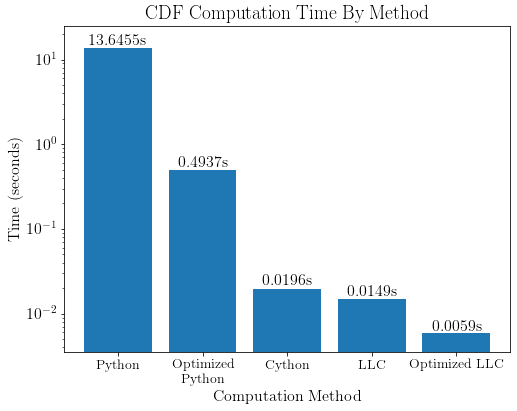

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['figure.figsize'] = [8, 6]
matplotlib.rcParams.update({'font.size': 16})

fig, ax = plt.subplots()
inputs = [python_quad,
          improved_python,
          optimized_cython,
          LLC_nquad, 
          optimized_LLC
          ]
index = np.arange(len(inputs))
times = [input.best for input in inputs]
t = ax.bar(index, times)
ax.set_yscale('log')
ax.set_ylabel("Time (seconds)")
ax.set_xlabel("Computation Method")

ax.set_title("CDF Computation Time By Method")
ax.set_xticks(index)
labels = ("Python", "Optimized\nPython", "Cython", "LLC", "Optimized LLC" )
ax.set_xticklabels(labels)

# put label on top of each bar
for index, data in enumerate(times):
  plt.text(x = index,
           y = data ,
           s=f"{data:.4f}s",
           ha='center',
           va='bottom')
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.ylim(np.min(times)**1.1,10**1.4)

plt.show()

## Establishing Accuracy

One way of veryifying the accuracy of the wrapped LowLevelCallable as a solution to calculate the CDF is to compare its results against the already existing methods; the `statsmodels` package has an implementation based off of interpolating between existing studentized range tables there is an R interface for wrapped Fortran code. However, neither of these are both modern and full implementations of the integral. Therefore, it is neccesary to determine a way to establish the ground truth values to compare against.

### Determining Ground Truth

To fully flesh out the accuracy of our methods used in our cython implementation, we want to come up with a method that is unoquivocally accurate. For this, we turn to [`mpmath`](https://mpmath.org/), a Python library for floating point arithmetic with arbitrary precision. There is a cost of this increased precision; `mpmath` integrations can take many seconds for increased precision. 

The goal is to determine a ground truth value, so the path we follow is to implement the integral with `mpmath` functions, using two separate methods of integration, *tanh-sinh quadrature* and *Gauss-Legendre quadrature*, and then increase the degrees of precision until the results converge. While the `mpmath` functions used for this exercise are shown in the following cells, their outputs are provided due to the time needed to run them, which is in excess of 10 minutes.

In [ ]:
from mpmath import gamma, pi, erf, exp, sqrt, quad, inf, mpf
from mpmath import npdf as phi
from mpmath import ncdf as Phi
from mpmath import mp


def _cdf_mp(q, k, nu, method, verbose=True, error=True, dps=15):
  mp.dps = dps
  q, k, nu = mpf(q), mpf(k), mpf(nu)

  def inner(s, z):
    return phi(z)*(Phi(z+q*s)-Phi(z))**(k-1)

  def outer(s, z):
    return s**(nu-1)*phi(sqrt(nu)*s)*inner(s, z)

  def whole(s, z):
    return sqrt(2*pi)*k*nu**(nu/2) / (gamma(nu/2)*2**(nu/2-1))*outer(s, z)
  res = quad(whole, [0, inf], [-inf, inf], error=error,
             method=method, maxdegree=10)
  return res

def cdf_mp_gl(q, k, nu, verbose=True, error=True, dps=15):
  return _cdf_mp(q, k, nu, method='gauss-legendre', verbose=verbose,
                error=error, dps=dps)

def cdf_mp_ts(q, k, nu, verbose=True, error=True, dps=15):
  return _cdf_mp(q, k, nu, method='tanh-sinh', verbose=verbose, error=error,
                 dps=dps)


def eval_over_dps_range(q, k, v, dps_range):
  ts_cdf = []
  gl_cdf = [] 
  for dps in dps_range:
    print(dps)
    ts_cdf.append(cdf_mp_ts(q, k, v, dps=dps)[0])
    gl_cdf.append(cdf_mp_gl(q, k, v, dps=dps)[0])
  return ts_cdf, gl_cdf


As the degrees of precision increases, the absolute difference between the *tanh-sinh* and Gauss-Legendre quadrature integration methods converge. Therefore, we establish that the ground truth value to be the average of the gauss-legendre and tanh-sinh methods at 25 degrees of precision. Data has been generated for this arbitrarily selected set of parameters: 
$$q, k, \nu = 4.577, 10, 10$$

In [ ]:
# mpmath computation is very slow, so the results have been precomputed
!git clone https://github.com/swallan/srdcolab.git
mp.dps = 25
with open('srdcolab/gl_cdf.npy', 'rb') as f:
    gl_cdf = np.load(f, allow_pickle=True)
with open('srdcolab/ts_cdf.npy', 'rb') as f:
    ts_cdf = np.load(f, allow_pickle=True)

fatal: destination path 'srdcolab' already exists and is not an empty directory.


In [ ]:
gt = (gl_cdf[-1] + ts_cdf[-1]) / 2
print(gt)

0.8602913886732686811098036


### Comparing against ground truth

At various degrees of precision ("espilon"), we would like to examine the relative absolute error of the presented Cython implementation, R's `ptukey` and `statsmodels`. Like the digits of precision in `mpmath`, we utilize the `epsabs` parameter when integrating over the Cython LowLevelCallable to adjust the level of precision. We calculate the result of the function at different levels of precision to examine the absolute accuracy. R and StatsModels do not provide an interface for the possibility of increased precision, so their results are constant.


We compute the results of the CDF for SciPy, StatsModels, and R, and then find the absolute error from the ground truth value. 

In [ ]:
# SciPy
from mpmath import mpf, fabs, mp
import numpy as np
import scipy.integrate as integrate
import ctypes

mp.dps = 25
q, k, v = 4.577, 10, 10

def cython_cdf(dps):
  log_const = srd.studentized_range_cdf_logconst(k, v)
  usr_data = np.array([q, k, v, log_const], float).ctypes.data_as(ctypes.c_void_p)
  llc = LowLevelCallable.from_cython(srd, "_studentized_range_cdf", usr_data)
  ranges = [(-np.inf, np.inf), (0, np.inf)]
  atol = 10**-(dps)
  opts = dict(epsabs=atol)
  return nquad(llc, ranges=ranges, opts=opts)[0]

dps_range = range(5, 25)
cython = []

for dps in dps_range:
  cython.append(cython_cdf(dps))


StatsModels does not have a toggle for accuracy, so its result is constant.

In [ ]:
from statsmodels.stats.libqsturng import psturng
def statsmodels_cdf(q, k, v):
  # `psturng` returns the `alpha` value, which we 
  # convert to a p-value. 
  return 1 - psturng(q, k, v)

sm_cdf = [statsmodels_cdf(q, k, v)] * len(dps_range)

R's accuracy is fixed, so its result is constant.

In [ ]:
%load_ext rpy2.ipython 

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
# execute R code and return the result to a python variable
%%R -o cdf_r_single
cdf_r_single <- ptukey(4.577, 10, 10)

In [ ]:
cdf_r = [cdf_r_single[0]] * len(dps_range)

Calculate relative error for each sample at 25 `dps`.

In [ ]:
from mpmath import mpf, fabs, mp
import numpy as np

mp.dps = 25

cython_err = [fabs(c - gt)/gt for c in cython]
gl_err = [fabs(gl - gt)/gt for gl in gl_cdf]
ts_err = [fabs(ts - gt)/gt for ts in ts_cdf]
sm_err = [fabs(sm - gt)/gt for sm in sm_cdf]
r_err = [fabs(r - gt)/gt for r in cdf_r]

Using the relative error, we can compare the accuracy of each of the methods in a chart. 

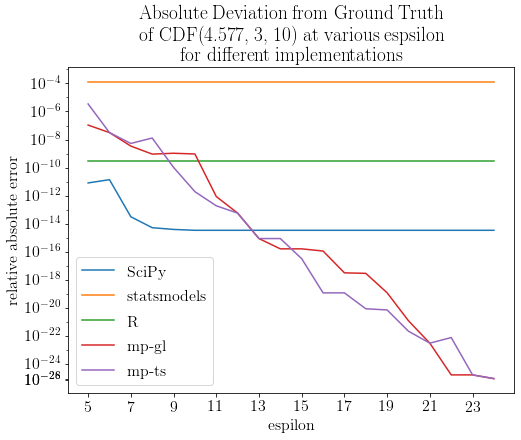

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# styling setup
plt.rc('font', family='serif')
matplotlib.rcParams['figure.figsize'] = [8, 6]
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots()

# corresponding x axis values
rng = list(range(5, 25))
ax.semilogy(rng, cython_err, rng, sm_err, rng, r_err, rng, gl_err, rng, ts_err)
ax.legend(("SciPy", "statsmodels", "R", "mp-gl", "mp-ts"))
ax.set_title(f"Absolute Deviation from Ground Truth\nof CDF({q}, {k}, {v})"
              " at various espsilon\nfor different implementations")
ax.set_ylabel("relative absolute error")
ax.set_xlabel("espilon")

plt.xticks(range(5, 25, 2))

data = np.asarray([cython_err, sm_err, r_err, gl_err, ts_err])
labels = ["SciPy", "statsmodels", "R", "mp-gl", "mp-ts"]

ax.set_yscale('symlog', linthreshy=1e-24)

# set the number of ticks on the y axis.
locmaj = ticker.LogLocator(base=10, numticks=16) 
ax.yaxis.set_major_locator(locmaj)

plt.show()


As stated the `mpmath` implementations for *tanh-sinh* and *gauss legendre* converge to the same value as the digits of precision increases. StatsModels is accurate to the fourth decimal place, R is accurate to the ninth decimal place, and SciPy levels off in accuracy to about 14 decimal places at 9 digits of precision. 

### Affirming of Statistical Significance of Accuracy


We observe that SciPy has a high degree of accuracy for the above arbitrarily selected case. We would like to say that this method is accurate for most computations, so we rely on two statistical tests in a simulation:

- Binomial Test
- Bootstrap Confidence Intervals of Error



#### Experimental Setup
For this simulation, 1000 randomly generated sets of $q, k, $ and $\nu$ values were evaluated with `mpmath` at 18 digits of precision, more than number of digits that Python floats can have. The process of generating $q, k, $ and $\nu$ was intended to cover most common scenarios.

For each of the 1000 observations:
 1. a $k$ was randomly generated uniformly in the range 1, the minimum value supported by the distribution, through 120, the largest finite value provided by most available online tables.
 2. a $\nu$ was randomly generated uniformly in the range 2 through 100, with bounds chose for the same reason as above.
 3.  A $p$ value was randomly generated uniformly in the range 0 through 1, and then the corresponding $q$ was determined from the distribution with the given $k$ and $\nu$. 


We define the `mpmath` implementation at 18 digits of precision to be the ground truth value, as it was observed that at 18 digits of precision, `mpmath` yields more accuracy than standard python float which only holds 16 decimals:
$$
F_{MP}(q; k, v) 
$$

Similarly, we define the implementations for SciPy, StatsModels, and R:
$$F_{SP}(q; k, v) \\
\\
F_{SM}(q; k, v) \\
F_{R}(q; k, v)^*$$


$^*$ the R implementation does not support parameters where $\nu = 0$. For the sake of quantitative comparison, these results have been filtered out.

The following cell's function is to load in the data and convert it to list form.

In [ ]:
with open('srdcolab/glnp.npy', 'rb') as f:
    gl_l = np.load(f, allow_pickle=True)
with open('srdcolab/smnp.npy', 'rb') as f:
    sm_l = np.load(f)
with open('srdcolab/cnp.npy', 'rb') as f:
    c_l = np.load(f)
with open('srdcolab/rnp.npy', 'rb') as f:
    r_l = np.load(f)

The absolute errors for SciPy, StatsModels, and R were then calculated according to the ground truth value from `mpmath`:

$$
SP_{ERR} = \mathrm{abs}(F_{MP}(q; k, v) - {F_{SP}}(q; k, v)\\
SM_{ERR} = \mathrm{abs}(F_{MP}(q; k, v) - F_{SM}(q; k, v) \\
R_{ERR} = \mathrm{abs}(F_{MP}(q; k, v) - F_{R}(q; k, v) 
$$

  


In [ ]:
cython_errors = np.asarray(np.abs(c_l - gl_l), dtype=float)
sm_errors = np.asarray(np.abs(sm_l - gl_l), dtype=float)
r_errors = np.asarray(np.abs(r_l - gl_l), dtype=float)

### Exact Binomial Test of Accuracy
We also the results of this implementation with the SciPy's binomial test [ref]. 

We would like to say that having less than 1e-12 absolute error constitues an accurate computation. Therefore, we conduct the test under the hypothesis that exactly 99% of results from the space are accurate. The alternative hypothesis is that the true percentage of results from the space that are accurate is greater than 99%. 

Out of 1000 results, 998 had errors less than than 1e-12. Our desired significance level is .01.

In [ ]:
# ensure the most recent version of SciPy is installed
!pip install scipy==1.7.0

In [ ]:
from scipy.stats import binomtest
res = binomtest(998, n=1000, p=.99, alternative="greater")
print(f"pvalue = {res.pvalue:.04f}")

pvalue = 0.0027


The p-value is much less than our desired significance level, $.002 < .01$. This is significant, so the null hypothesis is rejected in favor of the alternative, that the true percentage of the space for which the results are accurate is greater than 99.9%.

The binomial test result also provides confidence intervals based on the proportion of the estimate. Using the same confidence level as used during bootstrapped confidence interval estimation, 99.9%, we observe the range of proportions of a sample that are accurate in having less than 1e-12 absolute error. 

In [ ]:
res.proportion_ci(confidence_level=.999)

ConfidenceInterval(low=0.988822807558805, high=1.0)

Based on this result, we can expect that the interval $(.9888, 1)$ will contain the true proportion of accurate values 99.9% of the times for which this experiment were replicated.

### Bootstrapped Confidence Intervals Around Absolute Geometric Mean Error
For each method's absolute error, a bootstraped confidence interval was estimated around the geometric mean using `scipy.stats.bootstrap` for the confidence level of .999. The geometric mean was selected over the arithmatic mean as it provides a more accurate measure of central tendancy.


The results of these tests yeilded strong results. Data and generation scripts available upon request.

We estimate the confidence interval of the mean absolute error for SciPy, StatsModels, and R at the .999 confidence level. Examine the resulting table (below) for the confidence intervals.

In [ ]:
import scipy.stats as stats
from scipy.stats.mstats import gmean
statistic = gmean
rng = np.random.default_rng(123)
CI = .999


res_cython = stats.bootstrap((cython_errors,), statistic, confidence_level=CI, 
                             random_state=rng)
ci_cython = res_cython.confidence_interval

res_sm = stats.bootstrap((sm_errors,),statistic, confidence_level=CI, 
                             random_state=rng)
ci_sm = res_sm.confidence_interval        

r_errors_no_nans = r_errors[np.isfinite(r_errors)]  
res_r = stats.bootstrap((r_errors_no_nans,), statistic, confidence_level=CI, 
                             random_state=rng)
ci_r = res_r.confidence_interval 
  
def print_table(ci_cython, ci_sm, ci_r):
  '''print table showing upper and lower CI limits'''
  print(f"""     Mean Absolute Error CI
{CI*100}% Bootstrap Confidence Interval

method     |  lower ci  |  upper ci
-----------------------------------
SciPy      | {ci_cython.low:.3e}  | {ci_cython.high:.3e}
-----------------------------------
StatsModels| {ci_sm.low:.3e}  | {ci_sm.high:.3e}
-----------------------------------
R          | {ci_r.low:.3e}  | {ci_r.high:.3e}
"""
        )
print_table(ci_cython, ci_sm, ci_r)

     Mean Absolute Error CI
99.9% Bootstrap Confidence Interval

method     |  lower ci  |  upper ci
-----------------------------------
SciPy      | 2.133e-15  | 3.102e-15
-----------------------------------
StatsModels| 1.784e-03  | 3.105e-03
-----------------------------------
R          | 4.219e-09  | 8.553e-09



A confidence interval at the .999 level indicates that there is a 99.9% probability that the true error of the sample is contained within the interval.

The mean absolute error for the SciPy implementation was $2.59\mathrm{e}{-15}$, and the confidence interval indicates that there is a 99.9% probability that $2.133e\mathrm{e}{-15}$ and $3.102\mathrm{e}{-15}$ will contain the true error of the sample. 


$$
\mathrm{P}(\text{True Error of Sample} \ni [2.133e\mathrm{e}{-15}, 3.102\mathrm{e}{-15}]) = .999
$$


The magnitude of the confidence intervals for the SciPy implementation is much smaller than both StatsModels and R. 

Something that must be considered is the range of p-values used to generate the q values. Some methods may be more accurate for typical p-value ranges found in tables (Harter), such as those over .9. Filtering out all sets of $q, k$ and $\nu$ that produce p-values less than .9, we re-compute the confidence intervals:



In [ ]:
rng = np.random.default_rng(123)

# Filter out combinations with p-values below .9
cython_errors = np.asarray(np.abs(c_l - gl_l), dtype=float)[gl_l > .9]
sm_errors = np.asarray(np.abs(sm_l - gl_l), dtype=float)[gl_l > .9]
r_errors = np.asarray(np.abs(r_l - gl_l), dtype=float)[gl_l > .9]

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# This code mirrors the above comptution
res_cython = stats.bootstrap((cython_errors,), statistic, confidence_level=CI, 
                             random_state=rng)
ci_cython = res_cython.confidence_interval

res_sm = stats.bootstrap((sm_errors,),statistic, confidence_level=CI, 
                             random_state=rng)
ci_sm = res_sm.confidence_interval        

r_errors_no_nans = r_errors[np.isfinite(r_errors)]  
res_r = stats.bootstrap((r_errors_no_nans,), statistic, confidence_level=CI, 
                             random_state=rng)
ci_r = res_r.confidence_interval 

print_table(ci_cython, ci_sm, ci_r)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

     Mean Absolute Error CI
99.9% Bootstrap Confidence Interval

method     |  lower ci  |  upper ci
-----------------------------------
SciPy      | 6.176e-15  | 1.573e-14
-----------------------------------
StatsModels| 2.700e-05  | 8.886e-05
-----------------------------------
R          | 1.879e-10  | 1.238e-09



Both StatsModels and R increased in precision when using only combinations with p-values over .9. This result may not be as robust as the above result due to there being only 114 out of 1000 combinations with the requested p-value.  

### Accuracy Summary


Based on the results of the Bootstrapped Confidence Intervals and Binomial Test, we conclude that the test is accurate for a variety of values. Comparing the Bootstrapped confidence interval of the SciPy implementation to other methods showed that it is more accurate to ground truth by several orders of magnitude.

The Binomial Test affirmed that we can expect the SciPy implementation to be accurate for a large proportion of computations based on the simulation created.

## Conclusion

The [PR](https://github.com/scipy/scipy/pull/13732) for the addition of this distribution was successfully merged into the main branch of SciPy on May 26, 2021. See the documentation page [here](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.stats.studentized_range.html). It makes use of this LowLevelCallable for the CDF and also implements many other attributes of the distribution. For example, we can compare the CDF and inverse CDF (PPF). 

In [ ]:
from scipy.stats import studentized_range
studentized_range.cdf(3.77, 3, 12)

0.9498176382394464

In [ ]:
studentized_range.ppf(0.95, 3, 12)

3.772928965726967

And plot the PDF:

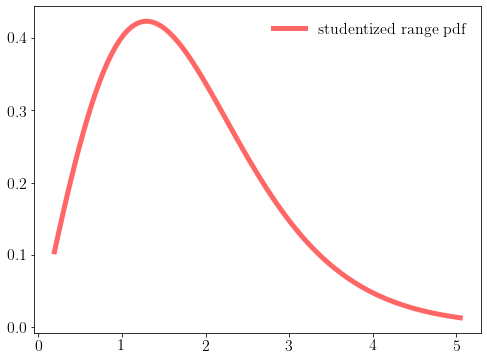

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
k, df = 3, 12
x = np.linspace(studentized_range.ppf(0.01, k, df),
                studentized_range.ppf(0.99, k, df), 100)
ax.plot(x, studentized_range.pdf(x, k, df),
        'r-', lw=5, alpha=0.6, label='studentized range pdf')
ax.legend(loc='best', frameon=False)
plt.show()

The test is also used in the under review [PR](https://github.com/scipy/scipy/pull/13002) for Tukey's Honestly Significant Difference test, which uses the studentized range's critical values. 

## References

[1] R. E. Lund and J. R. Lund, “Algorithm AS 190: Probabilities and Upper Quantiles for the Studentized Range,” Applied Statistics, vol. 32, no. 2, p. 204, 1983.

[2] H. L. Harter, “Use of Tables of Percentage Points of Range and Studentized Range,” Technometrics, vol. 3, no. 3, pp. 407–411, 1961.